# Documentation on how to use `dive`, how it works, and what is still missing

# Current dive usage

In the current stage it is possible to call dive with a few commands to analyze an arbitrary DEER signal with either regularization or Gaussian based MCMC methods. There are quite a few examples on how to analyse data in the `data_analyis` folder. The jupyer notebooks there are named after the data set they are analyzing. The data sets are based on Thomas' testset, and have a PID (distance distribution id) and an SID (time trace realization - mostly length and number of data points) that can be used to reference the distance distributions and form factors that are contained in the `mat` files. 

Back when we worked on the Gaussian paper, we took some of the S traces and turned them into full experimental traces by adding modulation depth, background and noise level. These are the traces that can be found in the data folder. 

## MWE of an analysis script

In [3]:
import pymc3 as pm
import matplotlib.pyplot as plt
import dive 
import numpy as np

In [4]:
loaded_data = np.genfromtxt("../data/2g_Pid-3223_Sid-36787.dat", skip_header = 1, delimiter = ',')
t = loaded_data[:,0]
Vexp = loaded_data[:,1]

In [5]:
pars = {"method": 'regularization', "r": np.linspace(2,6,200)}

model = dive.model(t, Vexp, pars)

MCMCparameters = {"draws": 4000,"tune": 1000, "chains": 4, 'cores': 4}
trace = dive.sample(model,MCMCparameters)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>SamplePfromV: [P]
>randDelta: [delta]
>NUTS: [k, V0, lamb, sigma]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 827 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The acceptance probability does not match the target. It is 0.8827032947295497, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k,0.064,0.001,0.062,0.066,0.000,0.000,4354.0,5821.0,1.0
λ,0.407,0.002,0.403,0.411,0.000,0.000,3295.0,4683.0,1.0
V₀,1.006,0.003,1.001,1.011,0.000,0.000,3523.0,5235.0,1.0
σ,0.007,0.000,0.007,0.008,0.000,0.000,8340.0,7943.0,1.0
δ,1554.870,521.140,658.256,2522.616,16.825,11.901,918.0,1825.0,1.0
lg(α),-0.546,0.076,-0.692,-0.409,0.002,0.002,958.0,2022.0,1.0


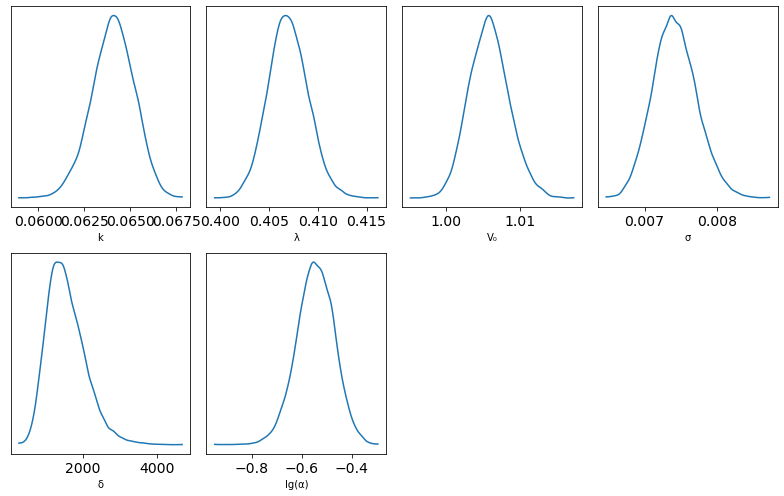

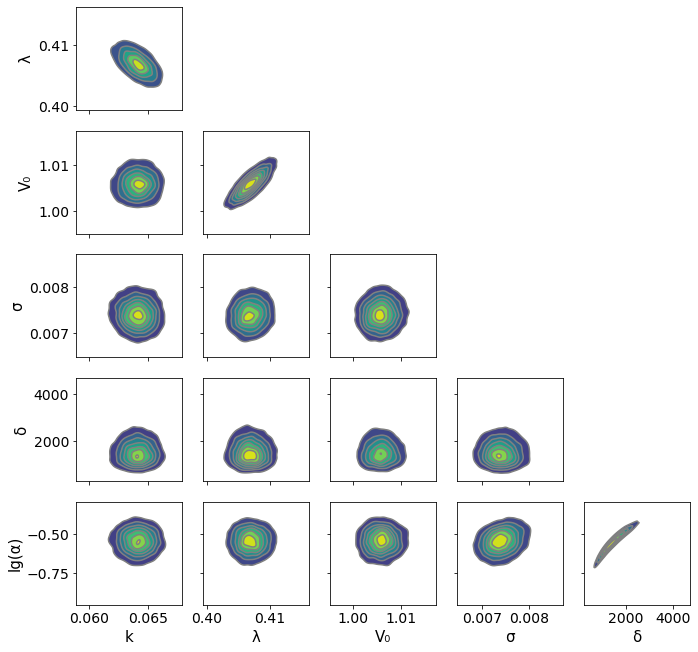

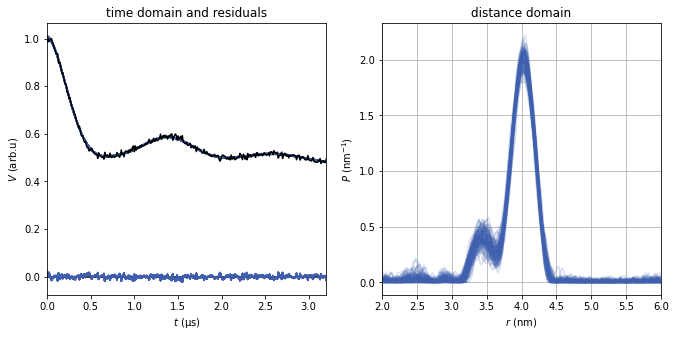

In [7]:
# It is possible to provide Pid to dive.summary(). This will load and plot the P from Thomas' test set.
dive.summary(trace, model)

# Development workflow

When developing new stuff or testing models etc, I usually work with jupyter notebooks until it is working, and then implement it in dive code.

For example, all the models were tested in jupyter note books, and then I used `dive.summary()` or `pm.summary()` to analyze the traces. Once the results were satisfying enough, I implemented the models in `dive` and wrote nicer wrappers around them to make it nice and shiny.

# ToDos

## Normalization (or not) of time domain traces

The time domain traces that are provided are normalized in a first step (see `Vscale` in `models.py`). This puts the maximum of the data at 1 and it is then analyzed with a prior centered around 1 for V0.

At the moment the results are presented (`dive.summary()`) with Vs normalized to 1. 

It might be worth scaling the results back before returning them (do that towards the end of `dive.sample()`). I don't think that this should mess with the represenation of the residuals (`plotting.py`), but it might be necessary to tweak this a little.

## What happens if a trace is not fully converged!?

If the trace does not completely converge during sampling, we increase the number of burnin and samples - easy, right?

At the moment, the samples from the nonconverged chain are discarded and a new trace object is created. Well, instead of throwing those away, wouldn't it be much nicer, and wayyyyy more efficient to just keep sampling where the previous chains ended. I'm pretty sure pymc3 supports this, and this should definitely be implemented.

## Making it more modular

Currently, three models are implemented:
* Gaussian
* Regularization
* Regularization with tau being sampled using NUTS (might get removed)

All these models are hardcoded. For example, this means that they all use an exponential decay as background. It would be a whole lot nicer to have more flexbility here, similar to `deerlab`.
It should be possible to build the model more modular like Lego bricks. E.g. have the user select a model for P (Gaussians, Rice, Tikhonov, ...), a model for background, and, in longterm, a model for the experiment. All these models would have to come with their own priors, which the user should not be possible to change. Also, a smart choice for default model will be necessary: Don't force the user to chose models.

The down side of this would be that this will also require a rewrite of the `dive.summary()` function, where the summaries are built depending on what kind of model is being used. But this should be relatively simple.

## Testing

The most important part. Currenlty there a no (or almost 0) unity tests implemented. Pretty much everything should be tested.

## Turning it into a full package

For now, `dive` exists in a state where it can be installed as a package, but it is not yet taking care of dependencies and is not hosted online. Luis would be a good contact for that. 

On a sidenote, a package named `dive` already exists, so we will have to come up with a different name.

## Might be worth unifying colors and plotsizes with what deerlab does (recognition value)

# Things I have noticed

## Gaussian fitting
When fitting with Gaussians, I have noticed a few things:

Sometimes convergence (R hat), can not be reached, as chains get stuck. 
- We had many discussions with Stefan about that. It is a property of our sampler and of how we set it up (sorting by position of the individual Gaussian components). There could be a few ways around it but we deemed that not necessary. 
- Stuck chains are usually easily identified, by one of the Gaussian components either being very diffuse (amplitudes, positions and widths all over the place) or by one of the amplitudes being zero.
- Here is an example for what could happen: Imagine fitting a P that has three distinc features with three Gaussians. In the ideal case the first Gaussian (µ₁) will fit the shortest feature, the position of the second Gaussian (µ₂) the feature in the middle and the third Gaussian (µ₃) the longest feature (This ordering is a result from our sort command in th e model definition - the first Gaussian is always the shortest distance). 
Now, it can happen that the sampler puts the position of the first Gaussian (µ₁) on the center feature of P, and since we enforce that the second Gaussian has to be at a longer distance than the first one, the second Gaussian now starts fitting the third feature. As we enforce µ₁ < µ₂ < µ₃, the third Gaussian does now longer have anything to fit, and the sampler walks around more or less randomly at the long distance end of r, with pretty much anything that it finds there only negatively contributing to logP (anything it finds there adds equally negatively to logP making it diffuse).
- Another reason for stuck chains can be that one (broad) feature is being fit by two Gaussians. An indicator for that can be if the mean of the position on one Gaussian is very similar to the mean of the position of a neighboring one (µᵢ ≈ µⱼ).

Overfitting is another issue that arises with Gaussian fitting
- One of the ways of tackling that is by using Bayesfactors (I dont think these are implemented in dive yet, might have to look up the MATLAB code on how thats done) - instead of calculating logP values and then summing them up as is done in the MATLAB implementation after the chains have been run, it might be possible to calculate and store logP values during the sampling (maybe it is even possible to sum them up!)
- There are two indicators for overfitting:
    - If you are using more Gaussians than there are features in the P(r), the longest distance Gaussian will be very diffuse as it is not being used to fit any of the features (similar to a stuck chain as described above)
    - There are a lot divergences during sampling

## Regularization